Geometry: NDBR50, Epoch [100/1000], Loss: 56703.2227
Geometry: NDBR50, Epoch [200/1000], Loss: 56688.0703
Geometry: NDBR50, Epoch [300/1000], Loss: 56671.7031
Geometry: NDBR50, Epoch [400/1000], Loss: 56652.5078
Geometry: NDBR50, Epoch [500/1000], Loss: 56629.8555
Geometry: NDBR50, Epoch [600/1000], Loss: 56602.7734
Geometry: NDBR50, Epoch [700/1000], Loss: 56570.0742
Geometry: NDBR50, Epoch [800/1000], Loss: 56530.4844
Geometry: NDBR50, Epoch [900/1000], Loss: 56482.6133
Geometry: NDBR50, Epoch [1000/1000], Loss: 56424.9023
Geometry: NDBR6, Epoch [100/1000], Loss: 56355.6367
Geometry: NDBR6, Epoch [200/1000], Loss: 56272.9961
Geometry: NDBR6, Epoch [300/1000], Loss: 56175.1875
Geometry: NDBR6, Epoch [400/1000], Loss: 56060.4961
Geometry: NDBR6, Epoch [500/1000], Loss: 55928.3789
Geometry: NDBR6, Epoch [600/1000], Loss: 55778.0156
Geometry: NDBR6, Epoch [700/1000], Loss: 55609.0156
Geometry: NDBR6, Epoch [800/1000], Loss: 55421.0391
Geometry: NDBR6, Epoch [900/1000], Loss: 55214.2969
G

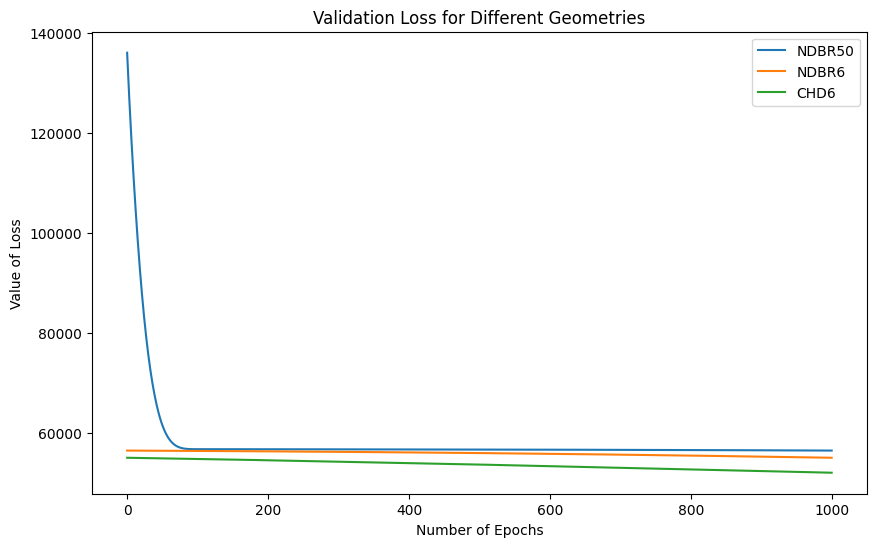

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

paramConfig = {
    'c1': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1.0, 'name': 'W', 'unit': 'dimensionless', 'type': 'hardening'},
    'c2': {'lowerBound': 0, 'upperBound': 2, 'exponent': 1000.0, 'name': 'K', 'unit': 'MPa', 'type': 'yielding'},
    'c3': {'lowerBound': 0, 'upperBound': 1, 'exponent': 0.1, 'name': 'e0', 'unit': 'dimensionless', 'type': 'hardening'},
    'c4': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1.0, 'name': 'n', 'unit': 'dimensionless', 'type': 'hardening'},
    'c5': {'lowerBound': 0, 'upperBound': 2, 'exponent': 1000.0, 'name': 'sigma_y', 'unit': 'MPa', 'type': 'yielding'},
    'c6': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1000.0, 'name': 'sigma_sat', 'unit': 'MPa', 'type': 'hardening'},
    'c7': {'lowerBound': 0, 'upperBound': 1, 'exponent': 1000.0, 'name': 'b', 'unit': 'dimensionless', 'type': 'hardening'}
}

geometries = ['NDBR50', 'NDBR6', 'CHD6']

yieldingIndices = {'NDBR50': 200, 'NDBR6': 200, 'CHD6': 1200}

# Load data from CSV files
X_file = "MODEL_DATA/reduced_fd.csv"
Y_file = "MODEL_DATA/converted.csv"

X_df = pd.read_csv(X_file)  # Load the X data
Y_df = pd.read_csv(Y_file)  # Load the Y data

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_df.values, dtype=torch.float32)
Y_train = torch.tensor(Y_df.values, dtype=torch.float32)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the number of input features, hidden units, and output dimensions
input_size = X_train.shape[1]  # Number of input parameters
hidden_size = 64  # Number of hidden units
output_size = Y_train.shape[1]  # Number of output dimensions

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, output_size)

# Define a loss function (mean squared error) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000  # Adjust the number of epochs as needed

# Lists to store loss values for each geometry
loss_lists = {geometry: [] for geometry in geometries}

for geometry in geometries:
    num_samples = yieldingIndices[geometry]

    X_sample = X_train[:num_samples]
    Y_sample = Y_train[:num_samples]

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss
        loss = criterion(outputs, Y_sample)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_lists[geometry].append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the validation set
model.eval()
with torch.no_grad():
    Y_pred = model(X_val)
    val_loss = criterion(Y_pred, Y_val)

print(f'Validation Loss: {val_loss.item():.4f}')

# Create a plot for the validation loss
plt.figure(figsize=(10, 6))
plt.plot(loss_lists['NDBR50'], label='NDBR50')
plt.plot(loss_lists['NDBR6'], label='NDBR6')
plt.plot(loss_lists['CHD6'], label='CHD6')
plt.xlabel('Number of Epochs')
plt.ylabel('Value of Loss')
plt.legend()
plt.title('Validation Loss for Different Geometries')
plt.show()
